# Exoplanets A: Lab Assignment
*Author: Lukas Welzel*

## Purpose
Collect all plots for the assignment.

## WIP - improvements
Notable TODOs:
-


# Setup

## Library import

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import matplotlib as mpl
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines # TODO: cite https://github.com/cphyc/matplotlib-label-lines here https://zenodo.org/record/7428071
# TODO: put in pull request for above modification to supply custom labels to each line in labellines
from matplotlib.widgets import Slider, Button
from mpl_toolkits.axes_grid1 import make_axes_locatable
RGbinary = mpl.colors.ListedColormap(['red', 'green'])

import seaborn as sns
import mpld3
from ipywidgets import *

%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 300

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# other
from tqdm import tqdm
from copy import deepcopy
from itertools import product

## Local library import

In [3]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries
from read_all_planets import read_experiments_hdf5

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# Data import
We retrieve all the required data for the analysis.

In [4]:
# data is hierarchical dict with all experiment data in the structure:
#   failed_configs:             df with config information for those that failed to run properly
#   run-m_core-VALUE-f-VALUE:   dict with single experiment data    - e.g. run-m_core-3_0-f-0_1
#       header                  dict with header data               - 'burn_min1', 'burn_min2', 'f', 'initial_mass',
#                                                                     'initial_z', 'm_core', 'name', 'path', 'success', 'version_number'
#       history                 df with history data                - 'log_star_age', 'luminosity', 'radius', 'star_mass',
#                                                                     'surface_cell_temperature', 'conv_mx1_top_r', 'conv_mx1_top',
#                                                                     'center_entropy', 'max_entropy', 'log_L', 'log_Teff', 'log_center_T',
#                                                                     'log_center_Rho', 'log_R'
#       global_properties       df with global data at step         - 'step', 'model_number', 'num_zones', 'star_age', 'Teff',
#                                                                     'photosphere_L', 'photosphere_r', 'star_mass', 'power_nuc_burn'
#       zone_properties         df with zone data at step           - 'zone', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H',
#                                                                     'y_mass_fraction_He', 'z_mass_fraction_metals', 'mu', 'grada',
#                                                                     'opacity', 'gradT', 'gradr', 'sch_stable', 'ledoux_stable'
#   run-m_core-VALUE-f-VALUE...
#
# the zone_properties df has a hierarchical index "step" which corresponds to the "step" column in the global_properties df
#
# UNITS
#
#    radius ! radius at outer boundary of zone (in Rsun units)
#    luminosity ! luminosity at outer boundary of zone (in Lsun units)
#    logL ! log10(max(1d-2,L/Lsun))
#    star_mass ! in Msun units
#    zone       ! numbers start with 1 at the surface
#    mass       ! m/Msun. mass coordinate of outer boundary of cell.
#    logR       ! log10(radius/Rsun) at outer boundary of zone
#    logT       ! log10(temperature) at center of zone
#    logRho     ! log10(density) at center of zone
#    logP       ! log10(pressure) at center of zone
#    mu ! mean molecular weight per gas particle (ions + free electrons)


DATA_FILE = "exoplanet_A_MESA_lab_GS_RS_LONG.hdf5"

data = read_experiments_hdf5(loc=DATA_FILE)

failed_experiments = deepcopy(data["failed_configs"])
del data["failed_configs"]

# Data processing
## Preprocessing

In [5]:
entries = [key for key in data.keys()]

def get_data_from_hist(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["history"][cols]] for entry in entries]

m_cores = np.array([entry[0] for entry in get_data_from_hist([])])
fs = np.array([entry[1] for entry in get_data_from_hist([])])

cross = np.array([m_cores, fs]).T
max_m_core = np.max(m_cores)
max_f = np.max(fs)

min_m_core = np.min(m_cores)
min_f = np.min(fs)

def get_data_from_zone(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["zone_properties"][cols]] for entry in entries]

def get_data_from_global(cols):
    return [[data[entry]["header"]["m_core"], data[entry]["header"]["f"], data[entry]["global_properties"][cols]] for entry in entries]

def get_final_values_from_zones(_planets):
    for i, planet in enumerate(_planets):
        _planets[i][-1] = planet[-1].xs(planet[-1].index.get_level_values(0)[-1])
    return _planets

In [6]:
# select data subset
# print(data)

m_p_core_list = [3., 5., 7., 10., 12.]
f_list = [0.1, 0.01]

inlist_values = list(product(m_p_core_list, f_list))

def reduce_to_ass_hist(cols):
    return [[data[entry]["header"]["m_core"],
             data[entry]["header"]["f"],
             data[entry]["history"][cols]]
            for entry in entries
            if (data[entry]["header"]["m_core"], data[entry]["header"]["f"]) in inlist_values]

def reduce_to_ass_zone(cols):
    return [[data[entry]["header"]["m_core"],
             data[entry]["header"]["f"],
             data[entry]["zone_properties"][cols]]
            for entry in entries
            if (data[entry]["header"]["m_core"], data[entry]["header"]["f"]) in inlist_values]

def reduce_to_ass_global(cols):
    return [[data[entry]["header"]["m_core"],
             data[entry]["header"]["f"],
             data[entry]["global_properties"][cols]]
            for entry in entries
            if (data[entry]["header"]["m_core"], data[entry]["header"]["f"]) in inlist_values]

In [7]:
def densify_planets(_planets):
    """
    Produce a dense DataFrame from a list of [[m_core, f, DataFrame], ...] where each row has the m_core, f as columns fo the DataFrame
    :param _planets:
    :return:
    """
    for i, planet in enumerate(_planets):
        _planets[i][2].insert(0, "m_core", planet[0])
        _planets[i][2].insert(1, "f", planet[1])
        _planets[i] = _planets[i][2]
    return pd.concat(_planets, axis=0)

def interp_planet_hist(xi, _planets, point_cols=["m_core", "f", "log_star_age"], value_cols=["radius"]):
    return griddata(points=_planets[point_cols].to_numpy(),
                    values=_planets[value_cols].to_numpy(),
                    xi=xi,
                    method="linear", rescale=True)


In [8]:


def color_m_core(_m_core, max=None, min=None):
    if max is None:
        max = max_m_core
    if min is None:
        min = min_m_core
    return mpl.colormaps['viridis']((_m_core - min) / (max - min))

def color_f(_f, max=None):
    if max is None:
        max = max_f
    return mpl.colormaps['viridis'](np.log10(max) / np.log10(_f))

def size_m_core(_m_core, max=None):
    if max is None:
        max = max_m_core
    return 20. * (_m_core / max) + 1.

def lw_m_core(_m_core, max=None):
    if max is None:
        max = max_m_core
    return 2. * (_m_core / max)

def lw_f(_f, max=None):
    if max is None:
        max = max_f
    return 2 * np.log10(max) / np.log10(_f)

### Failed Runs

In [29]:
planets = get_data_from_hist(["log_star_age", "radius", "star_mass"])
para = np.array([[p[0], p[1], 10 ** p[2]["log_star_age"].to_numpy()[0], 10 ** p[2]["log_star_age"].to_numpy()[-1], p[2]["radius"].to_numpy()[0]  * 109.076, p[2]["radius"].to_numpy()[-1]  * 109.076, p[2]["star_mass"].to_numpy()[0] * 333030] for p in planets])

df = pd.DataFrame(para, columns=["m_core", "f", "star_age_0", "star_age_1", "radius_0", "radius_1", "star_mass"])

print(df.to_string())
df.to_csv("experiment_para.csv", float_format=r'$%.2e$')

        m_core         f    star_age_0    star_age_1    radius_0   radius_1  star_mass
0    10.000000  0.001000  2.537924e+01  5.000000e+09    2.781491   1.952032  10.009902
1    10.000000  0.002000  1.680173e+01  5.000000e+09    3.063405   1.991614  10.019932
2    10.000000  0.005000  4.563734e+01  5.000000e+09    3.586541   2.076193  10.050143
3    10.000000  0.010000  8.753913e+01  5.000000e+09    4.205194   2.180739  10.100901
4    10.000000  0.020000  4.091021e+02  5.000000e+09    5.170494   2.342600  10.203971
5    10.000000  0.050000  1.011276e+03  5.000000e+09    7.708377   2.703515  10.526202
6    10.000000  0.100000  1.768459e+03  5.000000e+09   11.614930   3.184898  11.110991
7    10.000000  0.200000  3.595663e+03  5.000000e+09   19.160161   3.983003  12.499865
8    10.000000  0.500000  1.547872e+07  5.000000e+09   10.534089   6.014071  19.999784
9    10.135167  0.076188  6.583666e+02  5.000000e+09    9.699235   2.973665  10.970910
10   10.219517  0.053138  5.111429e+02  5.0

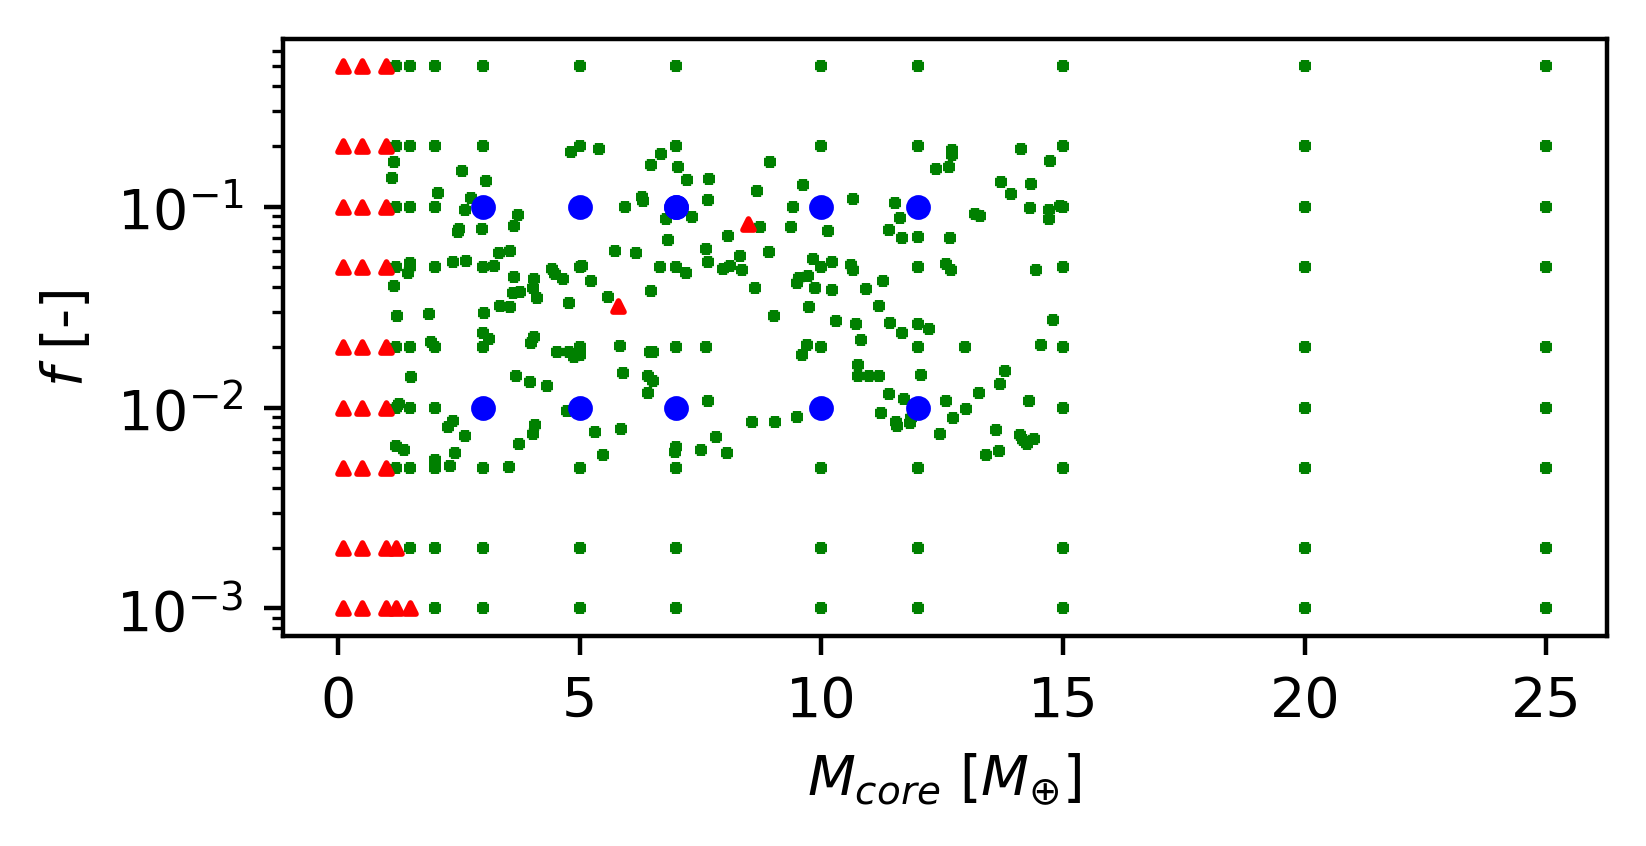

In [9]:
%matplotlib inline
unique_m_cores = np.unique(np.append(m_cores, failed_experiments["m_core"].to_numpy()))
unique_fs = np.unique(np.append(fs, failed_experiments["f"].to_numpy()))

planets = get_data_from_hist(["log_star_age"])
ass_planets = reduce_to_ass_hist(["log_star_age"])

print(planets)


fig, ax = plt.subplots(constrained_layout=True, figsize=(4,2))

def generate_rad_time_go_trace(planet, c="green", marker="+", **kwargs):
    m_core = planet[0]
    f = planet[1]
    trace = ax.scatter(m_core, f, c=c, marker=marker, **kwargs)
    return trace

for planet in planets:
    __ = generate_rad_time_go_trace(planet, s=4)
__ = generate_rad_time_go_trace(planet, s=4, label="Successful")

for planet in ass_planets:
    __ = generate_rad_time_go_trace(planet, c="blue", marker="o", s=12)
__ = generate_rad_time_go_trace(planet, c="blue", marker="o", s=12, label="Required")

ax.scatter(failed_experiments["m_core"], failed_experiments["f"], color="red", s=4, marker="^", label="Failed")

ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_title("Successful, failed and required experiments.", fontsize=8)
ax.set_xlabel(r"$M_{core}$ [$M_{\oplus}$]")
ax.set_ylabel(r"$f$ [-]")

plt.savefig("run_overview.png", dpi=350)

plt.show()

## Plotting

### Radius vs time
The evolution of the radius of the planets with time.

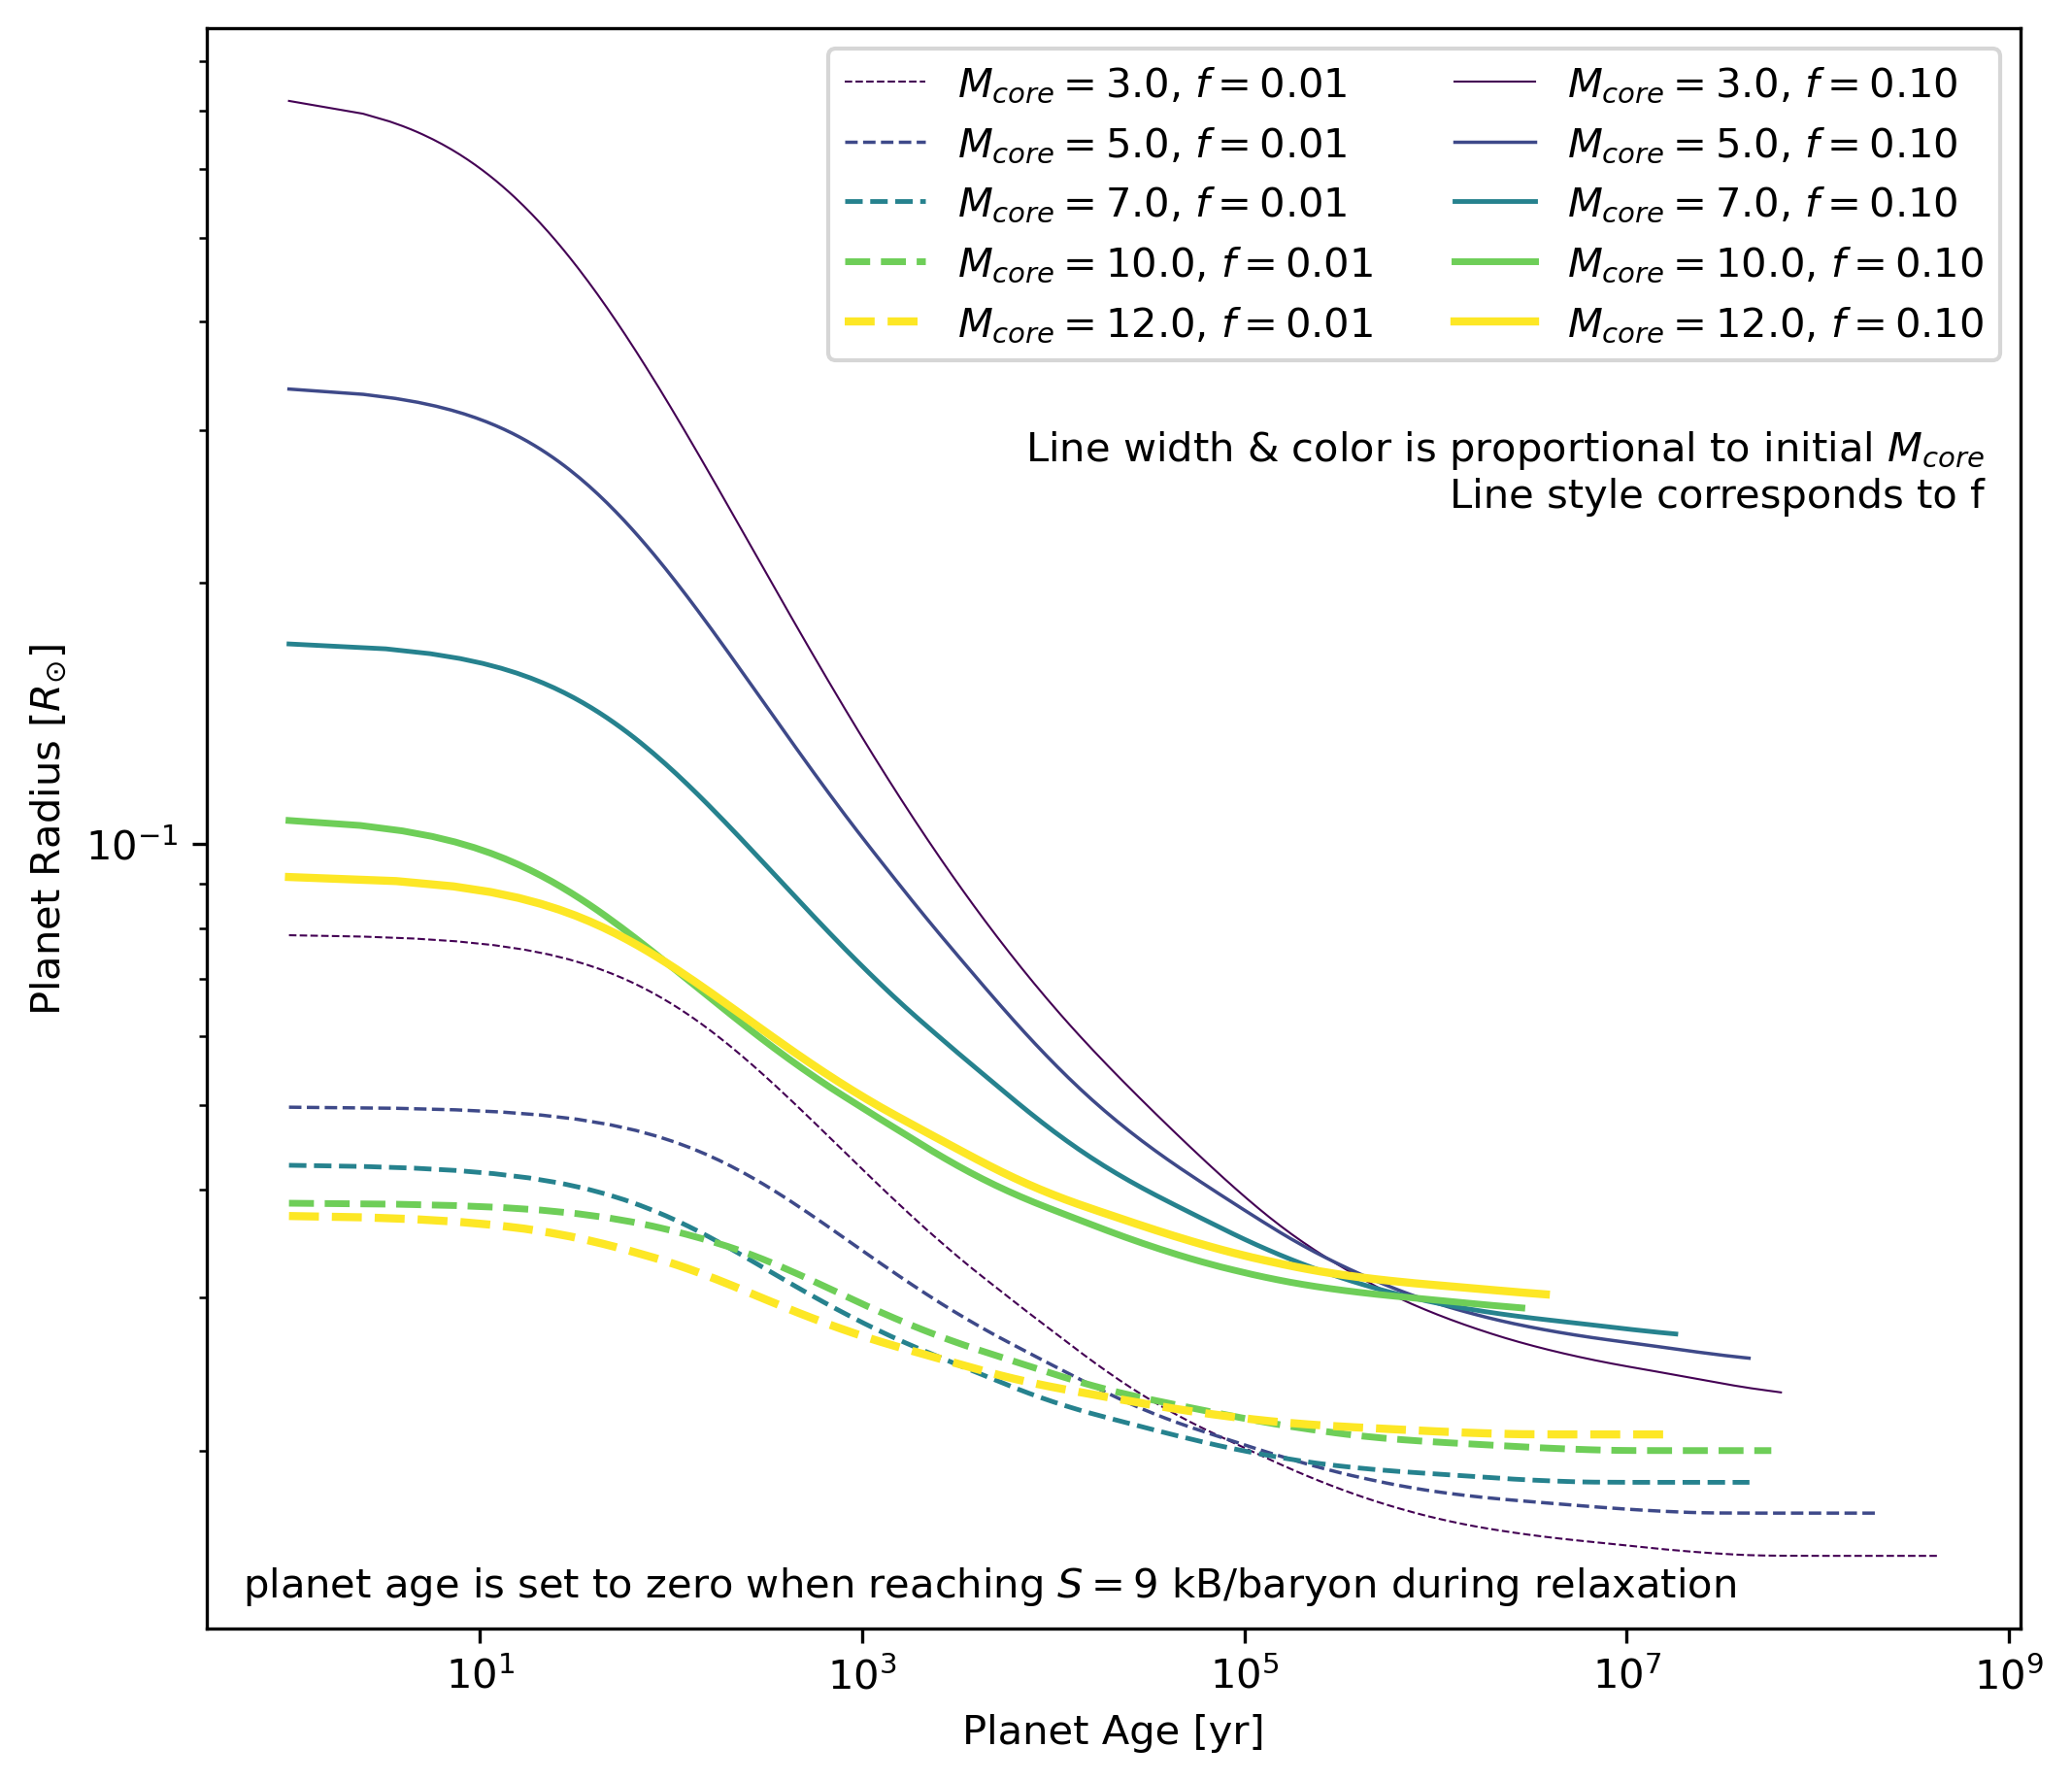

In [75]:
%matplotlib inline
# planets = get_data_from_hist(["radius", "log_star_age"])
planets = reduce_to_ass_hist(["radius", "log_star_age"])

fig, ax0 = plt.subplots(constrained_layout=True, figsize=(7,6))

def generate_rad_time_plt_trace(planet, i=0):
    m_core = planet[0]
    f = planet[1]
    if f==0.1:
        ls = "solid"
    else:
        ls="dashed"

    label =r"$M_{core}=$"+f"{m_core:00.1f}, " + r"$f=$" + f"{f:.2f}"

    radius = planet[2]["radius"].to_numpy()
    # radius = (radius - np.min(radius)) / np.max(radius - np.min(radius))
    # radius = radius / np.max(radius)
    # radius = radius / np.min(radius)
    log_star_age = planet[2]["log_star_age"].to_numpy()
    log_star_age = 10 ** (log_star_age - np.min(log_star_age)) # / np.max(log_star_age - np.min(log_star_age))
    # log_star_age = log_star_age / np.max(log_star_age)

    ax0.plot(log_star_age, radius, linewidth=lw_m_core(m_core, max=12.), c=color_m_core(m_core, max=12., min=3), ls=ls, label=label) # , lw= c=color_f(f)) #
    return

sorting = [4,6,8,0,2,5,7,9,1,3]

[generate_rad_time_plt_trace(planet) for planet in [planets[i] for i in sorting]]

t = "planet age is set to zero when reaching $S=9$ kB/baryon during relaxation"
ax0.annotate(t, xy=(0.02, 0.02), xycoords='axes fraction')

t = "Line width & color is proportional to initial $M_{core}$\nLine style corresponds to f"
ax0.annotate(t, xy=(0.98, 0.75), xycoords='axes fraction', ha="right", va="top")

ax0.set_xlabel("Planet Age [yr]")
ax0.set_ylabel(r"Planet Radius [$R_{\odot}$]")
# ax0.set_ylim(-1, 1.)
ax0.set_yscale("log")
ax0.set_xscale("log")
ax0.legend(ncols=2)

plt.savefig("radius_star_age.png", dpi=350)
plt.show()

### final mass vs radius
The final mass vs. the final radius of the planets.

0.29077090522166144 0.004894390241316126


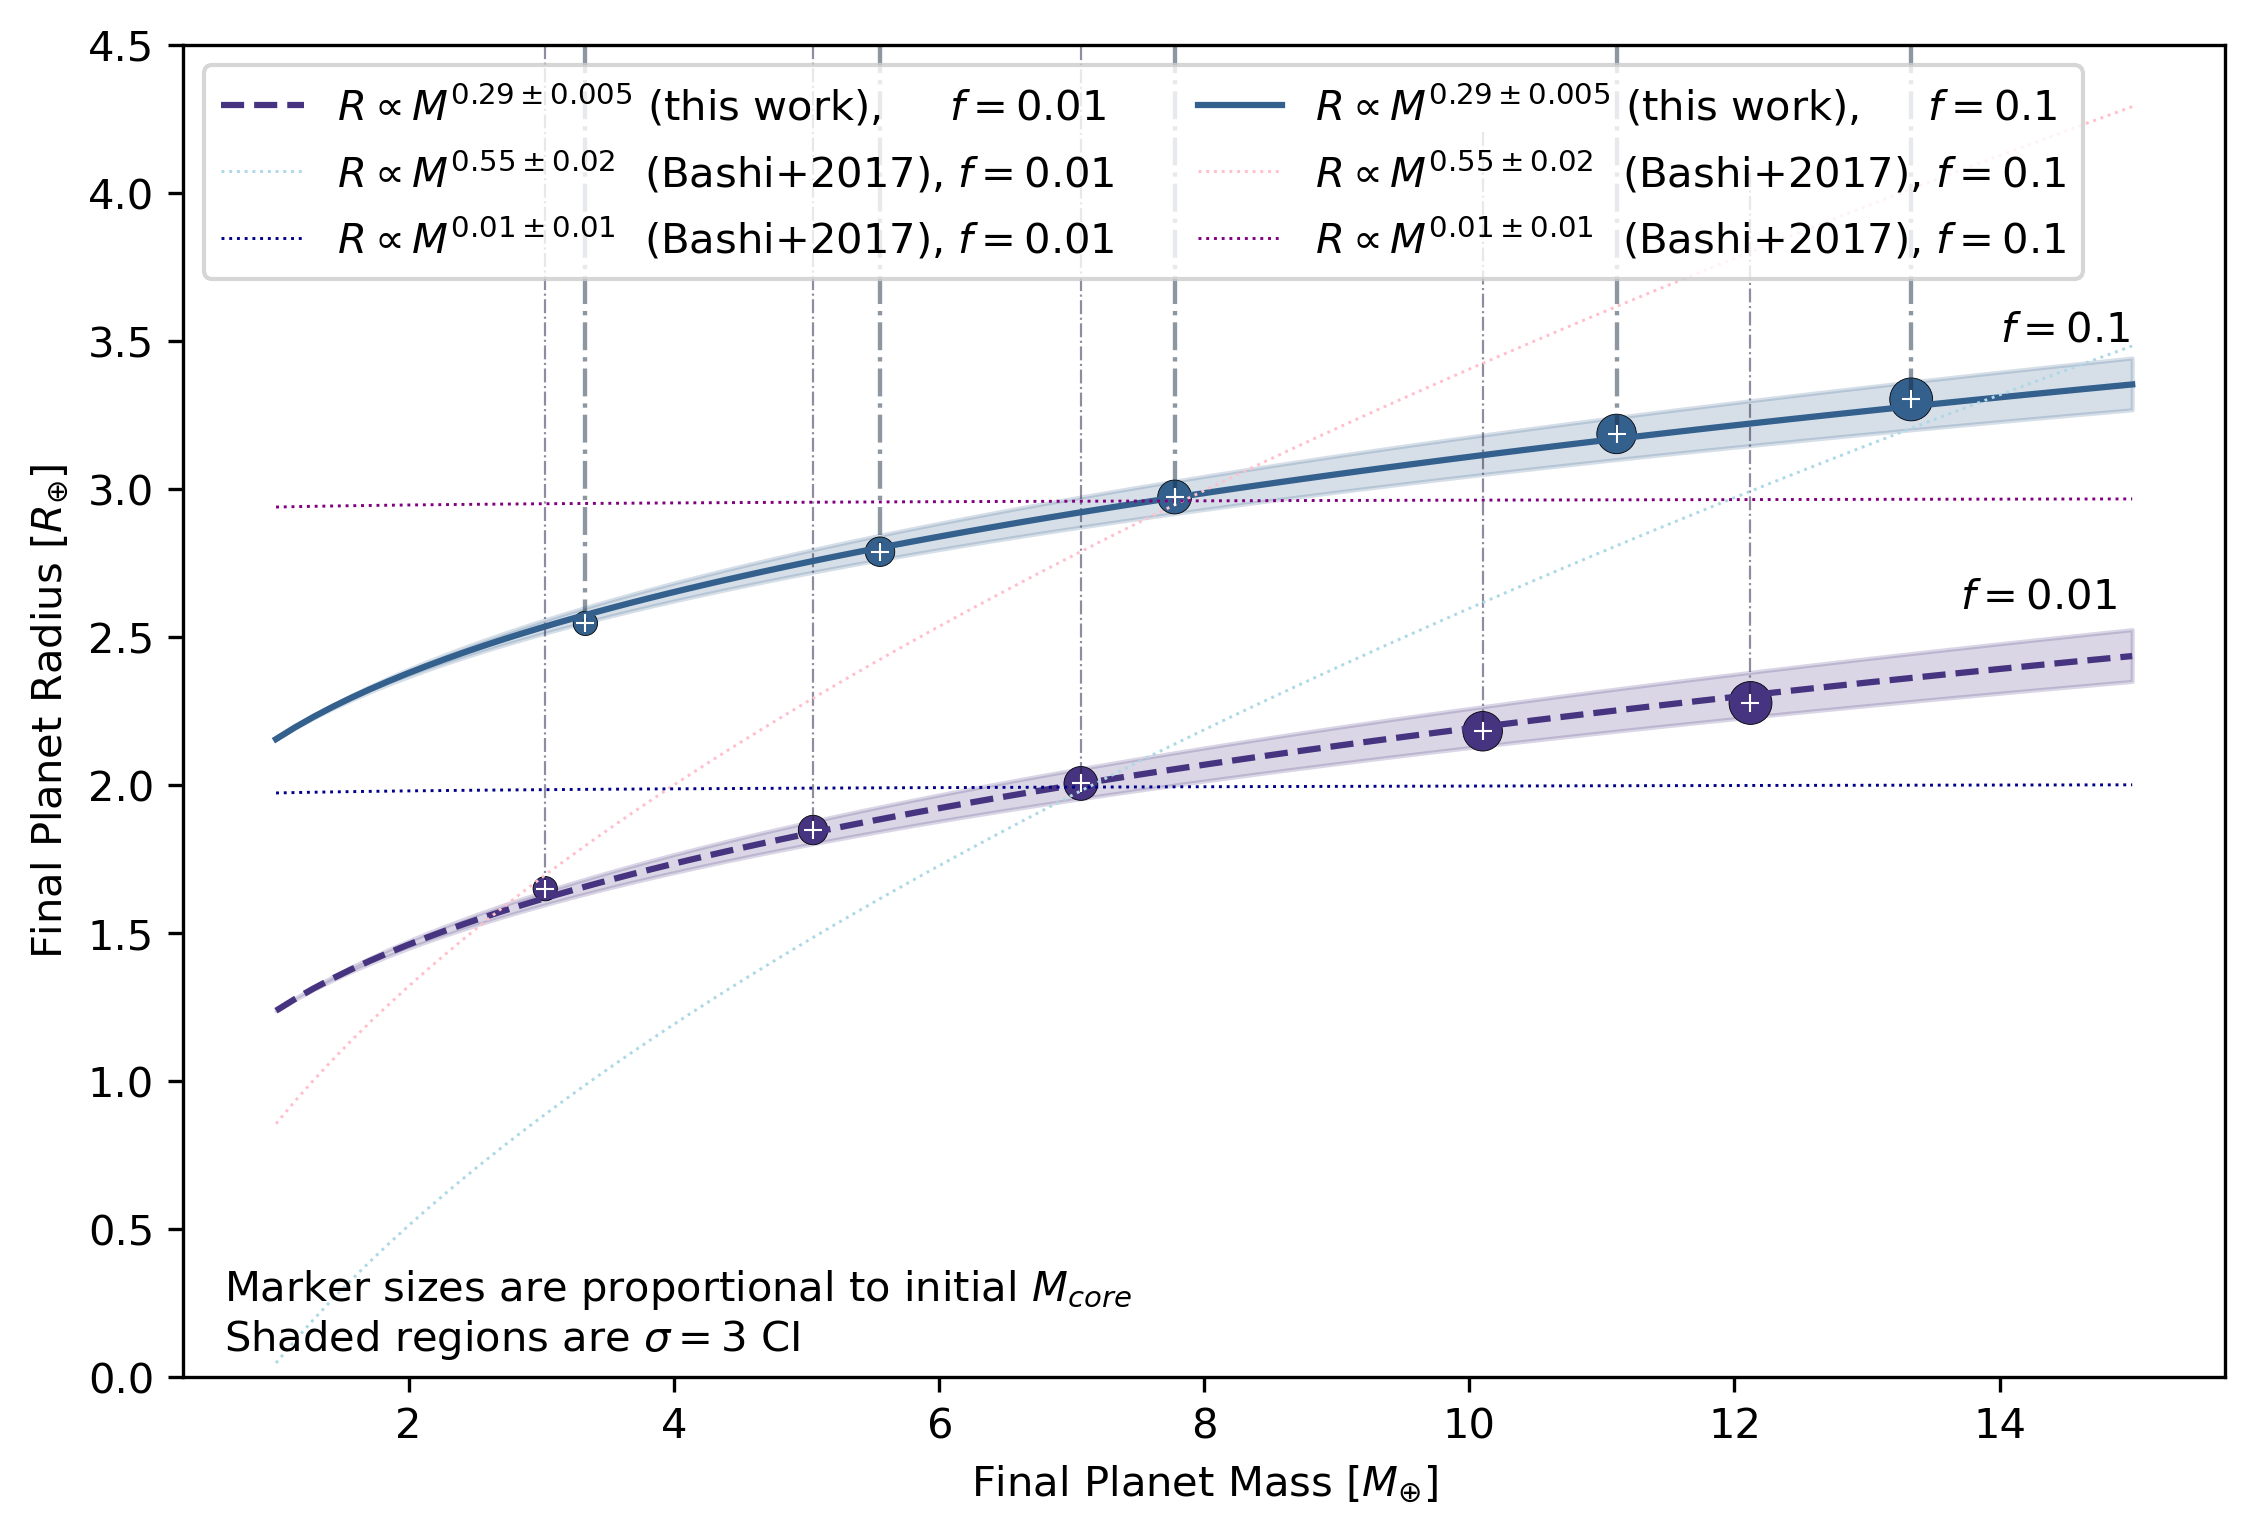

In [91]:
planets = reduce_to_ass_hist(["radius", "star_mass"])

fig, ax0 = plt.subplots(constrained_layout=True,figsize=(7.4,5))

def format_mass_rad(planet):
    m_core = planet[0]
    f = planet[1]
    radius = planet[2]["radius"].to_numpy() * 109.076
    star_mass = planet[2]["star_mass"].to_numpy()  * 333030

    ax0.plot(star_mass, radius, color=np.array(color_f(f)) * 0.5, linewidth=lw_f(f, max=0.3), ls="-.")

    return [star_mass[-1], radius[-1], m_core, f]

trace = np.array([format_mass_rad(planet) for planet in planets]).T

ax0.set_xlabel(r"Final Planet Mass [$M_{\oplus}$]")
ax0.set_ylabel(r"Final Planet Radius [$R_{\oplus}$]")

m_space = np.linspace(1.,  15., 100)

def m_r_power_law(m, a, b, offset):
    return m ** (a + b) + offset

def m_r_power_small_planets(m, offset, a=0.55, b=0):
    return m_r_power_law(m, a, b, offset)

def m_r_power_large_planets(m, offset, a=0.01, b=0):
    return m_r_power_law(m, a, b, offset)


m = np.concatenate(trace[0].reshape((-1, 2)).T, axis=0)
r = np.concatenate(trace[1].reshape((-1, 2)).T, axis=0)

def custom_double_fit(m, a, fitting=True, r=r):
    m1, m2 = np.split(m, 2)
    r1, r2 = np.split(r, 2)

    def m_r_power_these_planets(m, offset, a=a):
        return m_r_power_law(m, a=a, b=0, offset=offset)

    if fitting:
        para1 = curve_fit(m_r_power_these_planets, m1, r1, p0=[0.])
        para2 = curve_fit(m_r_power_these_planets, m2, r2, p0=[0.])

        y_pred_1 = m_r_power_these_planets(m1, offset=para1[0][0])
        y_pred_2 = m_r_power_these_planets(m2, offset=para2[0][0])

        return np.concatenate((y_pred_1, y_pred_2))
    else:
        para1 = curve_fit(m_r_power_these_planets, m1, r1, p0=[0.])
        para2 = curve_fit(m_r_power_these_planets, m2, r2, p0=[0.])
        return para1[0][0], para2[0][0]


para_a = curve_fit(custom_double_fit, m, r, p0=0.5)
para_a, std_a = para_a[0][0], np.sqrt(para_a[1][0][0])
para_offset1, para_offset2 = custom_double_fit(m, a=para_a, fitting=False)

print(para_a, std_a)

r_small, r_small_min, r_small_max = m_r_power_law(m_space, a=para_a, offset=para_offset1, b=0),\
                                    m_r_power_law(m_space, a=para_a, offset=para_offset1, b=-std_a * 3),\
                                    m_r_power_law(m_space, a=para_a, offset=para_offset1, b=std_a * 3)

ax0.fill_between(m_space, r_small_min, r_small_max, alpha=0.2, color=color_f(0.01))
ax0.plot(m_space, r_small, label=r"$R\propto M^{0.29\pm 0.005 }$ (this work),     $f=0.01$", ls="dashed", color=color_f(0.01))


r_small, r_small_min, r_small_max = m_r_power_law(m_space, a=para_a, offset=para_offset2, b=0),\
                                    m_r_power_law(m_space, a=para_a, offset=para_offset2, b=-std_a * 3),\
                                    m_r_power_law(m_space, a=para_a, offset=para_offset2, b=std_a * 3)

ax0.fill_between(m_space, r_small_min, r_small_max, alpha=0.2, color=color_f(0.1))
ax0.plot(m_space, r_small, label=r"$R\propto M^{0.29\pm 0.005 }$ (this work),     $f=0.1$", ls="solid", color=color_f(0.1))


small_offset_f01 = curve_fit(m_r_power_small_planets, [t[0] for t in trace.T if t[-1]==0.1], [t[1] for t in trace.T if t[-1]==0.1], p0=[0.0])[0][0]
small_offset_f001 = curve_fit(m_r_power_small_planets, [t[0] for t in trace.T if t[-1]==0.01], [t[1] for t in trace.T if t[-1]==0.01], p0=[0.0])[0][0]

r_small, r_small_min, r_small_max = m_r_power_small_planets(m_space, small_offset_f01), m_r_power_small_planets(m_space, small_offset_f01, b=-0.02), m_r_power_small_planets(m_space, small_offset_f01,  b=0.02)
ax0.plot(m_space, r_small, label=r"$R\propto M^{0.55\pm 0.02 }$  (Bashi+2017), $f=0.1$", ls="dotted", color="pink", lw=0.7)
# ax0.fill_between(m_space, r_small_min, r_small_max, alpha=0.2, color="gray")

r_small, r_small_min, r_small_max = m_r_power_small_planets(m_space, small_offset_f001), m_r_power_small_planets(m_space, small_offset_f001, b=-0.02), m_r_power_small_planets(m_space, small_offset_f001,  b=0.02)
ax0.plot(m_space, r_small, label=r"$R\propto M^{0.55\pm 0.02 }$  (Bashi+2017), $f=0.01$", ls="dotted", color="lightblue", lw=0.7)
# ax0.fill_between(m_space, r_small_min, r_small_max, alpha=0.2, color="gray")

large_offset_f01 = curve_fit(m_r_power_large_planets, [t[0] for t in trace.T if t[-1]==0.1], [t[1] for t in trace.T if t[-1]==0.1], p0=[0.0])[0][0]
large_offset_f001 = curve_fit(m_r_power_large_planets, [t[0] for t in trace.T if t[-1]==0.01], [t[1] for t in trace.T if t[-1]==0.01], p0=[0.0])[0][0]

r_small, r_small_min, r_small_max = m_r_power_large_planets(m_space, large_offset_f01), m_r_power_large_planets(m_space, large_offset_f01, b=-0.01), m_r_power_large_planets(m_space, large_offset_f01,  b=0.01)
ax0.plot(m_space, r_small, label=r"$R\propto M^{0.01\pm 0.01 }$  (Bashi+2017), $f=0.1$", ls="dotted", color="purple", lw=0.7)
# ax0.fill_between(m_space, r_small_min, r_small_max, alpha=0.2, color="gray")

r_small, r_small_min, r_small_max = m_r_power_large_planets(m_space, large_offset_f001), m_r_power_large_planets(m_space, large_offset_f001, b=-0.01), m_r_power_large_planets(m_space, large_offset_f001,  b=0.01)
ax0.plot(m_space, r_small, label=r"$R\propto M^{0.01\pm 0.01 }$  (Bashi+2017), $f=0.01$", ls="dotted", color="darkblue", lw=0.7)
# ax0.fill_between(m_space, r_small_min, r_small_max, alpha=0.2, color="gray")

ax0.scatter(trace[0], trace[1], color=color_f(trace[3]), edgecolor="black", linewidths=0.2, s=20 * size_m_core(trace[2])/2)
ax0.scatter(trace[0], trace[1], color="white", linewidths=0.5, s=20, marker="+", zorder=99)

t = r"$f=0.1$"
ax0.annotate(t, xy=(14, 3.5), xycoords='data')

t = r"$f=0.01$"
ax0.annotate(t, xy=(13.7, 2.6), xycoords='data')

import matplotlib.ticker as mticker

# class MathTextSciFormatter(mticker.Formatter):
#     """
#     https://stackoverflow.com/questions/25750170/show-decimal-places-and-scientific-notation-on-the-axis-of-a-matplotlib-plot
#     """
#     def __init__(self, fmt="%1.2e"):
#         self.fmt = fmt
#     def __call__(self, x, pos=None):
#         s = self.fmt % x
#         decimal_point = '.'
#         positive_sign = '+'
#         tup = s.split('e')
#         significand = tup[0].rstrip(decimal_point)
#         sign = tup[1][0].replace(positive_sign, '')
#         exponent = tup[1][1:].lstrip('0')
#         if exponent:
#             exponent = '10^{%s%s}' % (sign, exponent)
#         if significand and exponent:
#             s =  r'%s{\times}%s' % (significand, exponent)
#         else:
#             s =  r'%s%s' % (significand, exponent)
#         return "${}$".format(s)
#
# plt.gca().xaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
# plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 3, 5, 1, 2, 4]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncols=2, loc="upper left")

t = r"Marker sizes are proportional to initial $M_{core}$"+"\n"+"Shaded regions are $\sigma=3$ CI"
ax0.annotate(t, xy=(0.02, 0.02), xycoords='axes fraction')

# ax0.set_yscale("symlog")

ax0.set_ylim(0, 4.5)

plt.savefig("final_mass_radius.png", dpi=350)
plt.show()

### final radiative and adiabatic gradient vs radius
The final radiative and adiabatic gradient (both in the same plot) vs. the radius for each planet.

0.01999283737130629
0.029198892043668608
0.0208690292490702
0.030267727111539928
0.015118974872735629
0.023332995819783695
0.01693499814101532
0.02555162226415348
0.018377549557970056
0.027246795588808763


C:\Users\lukas\AppData\Local\Temp\ipykernel_11324\1425673303.py:216: UserWarning:

FixedFormatter should only be used together with FixedLocator



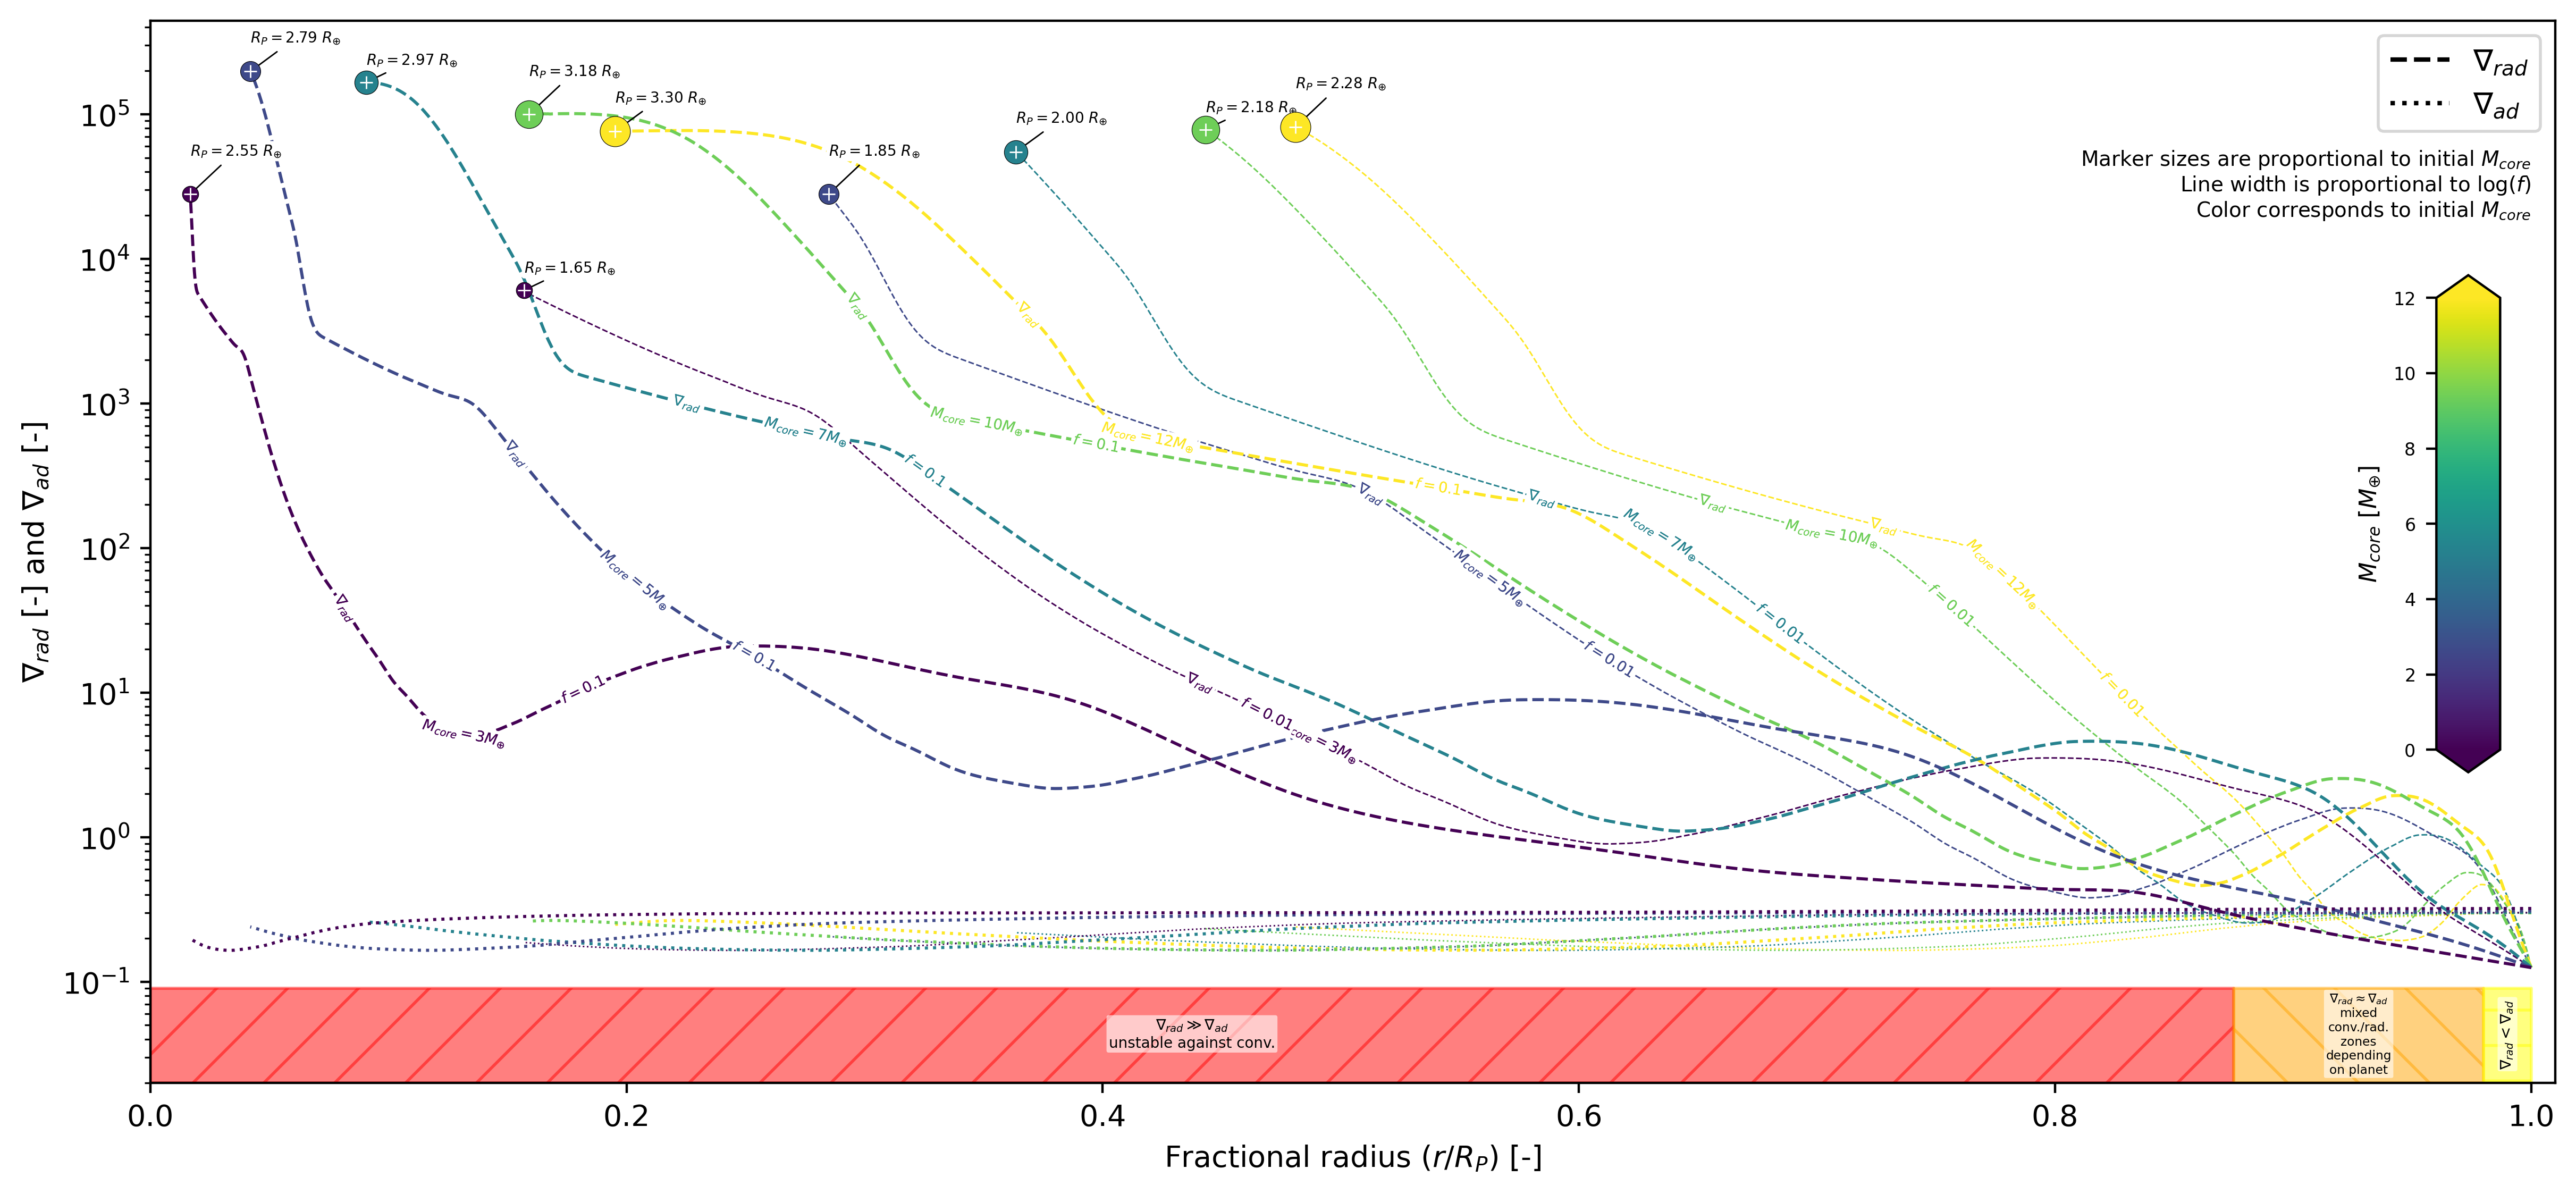

In [19]:
%matplotlib inline
# from zone_properties: 'grada', 'gradT', 'gradr',
# from history: radius

planets = reduce_to_ass_zone(['logR', 'grada', 'gradr'])
planets2 = reduce_to_ass_global(['star_age', "photosphere_r"])
planets3 = reduce_to_ass_hist(["radius"])

for i, p in enumerate(planets2):
    planets2[i][2] = p[2].iloc[-1].values[0]
    print(planets3[i][2]["radius"].iloc[-1])
    planets2[i].append(planets3[i][2]["radius"].iloc[-1])

planets = get_final_values_from_zones(planets)


fig, (ax0) = plt.subplots(constrained_layout=True, figsize=(12, 5.5))

bbox_white = {
    "boxstyle": "Round, pad=0.15",
    "edgecolor": "none",
    "facecolor": "white",
    "linewidth": 0.2,
}

linelabelpos = 0.

def generate_rad_grads_plt_trace(planet, planet2, i=0, **kwargs):
    m_core = planet[0]
    f = planet[1]
    age = planet2[2]
    radius = 10 ** planet[2]["logR"].to_numpy() * 109.076
    rp = planet2[3] * 109.076
    # radius = 10 ** planet[2]["logR"].to_numpy() * 109.076
    radius = radius / np.max(radius)
    # radius = (radius - np.min(radius)) / (np.max(radius) - np.min(radius))
    grada = planet[2]["grada"].to_numpy()
    gradr = planet[2]["gradr"].to_numpy()

    ax0.plot(radius, grada, ls="dotted",
             linewidth=lw_f(f, max=0.3), c=color_m_core(m_core, max=12, min=3),
             # linewidth=lw_m_core(m_core, max=12, min=3), c=color_f(f, max=0.3),
             **kwargs)
    ax0.plot(radius, gradr, ls="dashed",
             linewidth=lw_f(f, max=0.3), c=color_m_core(m_core, max=12, min=3),
             # linewidth=lw_m_core(m_core, max=12, min=3), c=color_f(f, max=0.3),
             **kwargs)

    ax0.scatter(radius[-1], gradr[-1],
                color=color_m_core(m_core, max=12, min=3),  s=5 * size_m_core(m_core, max=12),
                # color=color_f(f, max=0.3),  s=5 * size_m_core(m_core, max=12, min=3),
                edgecolor="black", linewidths=0.2, zorder=97)
    ax0.scatter(radius[-1], gradr[-1], color="white", linewidths=0.5, s=20, marker="+", zorder=98)



    t = r"$R_{P}=$"+f"{rp:.2f}" + r" $R_{\oplus}$"
    ax0.annotate(t, xy=(radius[-1], gradr[-1]),
                 xytext=(radius[-1], gradr[-1] * (1. + 0.5 + (0.5 * (((i - 1) % 3) / 2 - 0.5)))), # np.maximum(grada[1] - offset, 0.01)),
                 xycoords='data', textcoords='data',
                 fontsize=5, va="bottom", ha="left",
                 arrowprops={
                     "color": "black",
                     "linewidth": 0.5,
                     "arrowstyle": "-",
                 },
                 bbox=bbox_white,
                 )
    #
    # t = r"$\nabla_{rad}$" + f"\nf={f}\nm_core={m_core}"
    # ax0.annotate(t, xy=(radius[1], gradr[1]),
    #              xytext=(radius[1], gradr[1] * offset), # ] np.maximum(gradr[1] - offset, 0.01)),
    #              xycoords='data', textcoords='data',
    #              fontsize=5)

    # t = f"{i}"
    # ax0.annotate(t, xy=(radius[1], grada[1]),
    #              xytext=(radius[1], grada[1]), # np.maximum(grada[1] - offset, 0.01)),
    #              xycoords='data', textcoords='data',
    #              fontsize=5, va="top", ha="left")
    #
    # t = f"{i}"
    # ax0.annotate(t, xy=(radius[1], gradr[1]),
    #              xytext=(radius[1], gradr[1]), # ] np.maximum(gradr[1] - offset, 0.01)),
    #              xycoords='data', textcoords='data',
    #              fontsize=5)

    return

sorting = [2, 0, 8, 6, 4, 3, 1, 9, 7, 5]

sorted_planets = [(planets[i], planets2[i]) for i in sorting]

[generate_rad_grads_plt_trace(planet, planet2, i) for i, (planet, planet2) in enumerate(sorted_planets)]




offset_linelabel = 0.05

lines = ax0.get_lines()
labels = [[r" ", #  age={p2[2]:.1e}",
           r"$\nabla_{rad}$"] #  age={p2[2]:.1e}"]
          for i, (p1, p2) in enumerate(sorted_planets)]
labels = np.array(labels).flatten()

labelLines(lines=lines[1::2],
           labels=labels[1::2],
           align=True, xvals=(0.01, 0.8),
           fontsize=5,
           outline_color="none",
           # outline_color="black", outline_width=1,
           backgroundcolor="white",
           bbox=bbox_white,
           zorder=99,
           )

lines = ax0.get_lines()
labels = [[r"$M_{core} =$" + f"{p1[0]:.0f}" + r"$M_{\oplus}$", #  age={p2[2]:.1e}",
           r"$M_{core} =$" + f"{p1[0]:.0f}" + r"$M_{\oplus}$"] #  age={p2[2]:.1e}"]
          for i, (p1, p2) in enumerate(sorted_planets)]
labels = np.array(labels).flatten()
labelLines(lines=lines[1::2],
           labels=labels[1::2],
           align=True, xvals=(0.01 + offset_linelabel, 0.8 + offset_linelabel),
           fontsize=5,
           outline_color="none",
           # outline_color="black", outline_width=1,
           backgroundcolor="white",
           bbox=bbox_white,
           zorder=99,
           )

lines = ax0.get_lines()
labels = [[r"$f=$" + f"{p1[1]}", #  age={p2[2]:.1e}",
           r"$f=$" + f"{p1[1]}"] #  age={p2[2]:.1e}"]
          for i, (p1, p2) in enumerate(sorted_planets)]
labels = np.array(labels).flatten()
labelLines(lines=lines[1::2],
           labels=labels[1::2],
           align=True, xvals=(0.01 + 2 * offset_linelabel, 0.8 + 2 * offset_linelabel),
           fontsize=5,
           outline_color="none",
           # outline_color="black", outline_width=1,
           backgroundcolor="white",
           bbox=bbox_white,
           zorder=99,
           )

y = np.linspace(0.02, 0.09, 10)
x0 = 0. * np.ones_like(y)
x_conv = 0.875 * np.ones_like(y)
x_mixed = 0.98 * np.ones_like(y)
x_rad =  np.ones_like(y)

bbox={
    "boxstyle": "Round, pad=0.15",
    "edgecolor": "none",
    "facecolor": "white",
    "alpha": 0.6,
    "linewidth": 0.2,
}

plt.fill_betweenx(y, x0, x_conv,
                  alpha=0.5, color="red", hatch="/")

t = r"$\nabla_{rad} \gg \nabla_{ad}$"+f"\nunstable against conv."
ax0.annotate(t, xy=(np.mean([x0[0], x_conv[0]]), y[3]),
             xycoords='data',
             fontsize=5,
             color="black", bbox=bbox,
             ha="center", va="center")

plt.fill_betweenx(y, x_conv, x_mixed,
                  alpha=0.5, color="orange", hatch="\\")

t = r"$\nabla_{rad} \approx \nabla_{ad}$"+f"\nmixed\nconv./rad.\nzones\ndepending\non planet"
ax0.annotate(t, xy=(np.mean([x_conv[0], x_mixed[0]]), y[3]),
             xycoords='data',
             fontsize=4.2,
             color="black", bbox=bbox,
             ha="center", va="center")

plt.fill_betweenx(y, x_mixed, x_rad,
                  alpha=0.5, color="yellow", hatch="-")
t = r"$\nabla_{rad} < \nabla_{ad}$"
ax0.annotate(t, xy=(np.mean([x_mixed[0], x_rad[0]]), y[3]),
             xycoords='data',
             fontsize=5,
             rotation="vertical",
             color="black", bbox=bbox,
             ha="center", va="center")

ax0.plot([0., 0.5], [-1, -1], ls="dashed", color="black", label=r"$\nabla_{rad}$")
ax0.plot([0., 0.5], [-1, -1], ls="dotted", color="black", label=r"$\nabla_{ad}$")


t = r"Marker sizes are proportional to initial $M_{core}$"+"\n"+"Line width is proportional to $\log(f)$\nColor corresponds to initial $M_{core}$"
ax0.annotate(t, xy=(0.99, 0.88), xycoords='axes fraction', ha="right", va="top", fontsize=7)


cax = fig.add_axes([0.95, 0.35, 0.025, 0.425])

norm = mpl.colors.Normalize(vmin=0, vmax=12)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax, orientation='vertical',
                               # norm=mpl.colors.Normalize(0, 12),  # vmax and vmin
                               extend='both',
                               # label="$M_{core}$ [$M_{\oplus}$]",
                               # ticks=[0, 3, 6, 9],
                  )
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, fontsize=6)
cb.set_label("$M_{core}$ [$M_{\oplus}$]", fontsize=8)

# ax0.relim()      # make sure all the data fits
# ax0.autoscale()

ax0.set_xlabel(r"Fractional radius ($r / R_{P}$) [-]")
ax0.set_ylabel(r"$\nabla_{rad}$ [-] and $\nabla_{ad}$ [-]")
# ax0.set_xscale("log")
ax0.set_yscale("log")
ax0.set_ylim(0.02, None)
ax0.set_xlim(0.0, 1.01)
ax0.legend(loc="upper right")

plt.savefig("radius_gradients.png", dpi=350)
plt.show()

### final temperature vs pressure
The final temperature-pressure profile for each planet atmosphere.

C:\Users\lukas\AppData\Local\Temp\ipykernel_32672\4160295737.py:170: UserWarning:

FixedFormatter should only be used together with FixedLocator



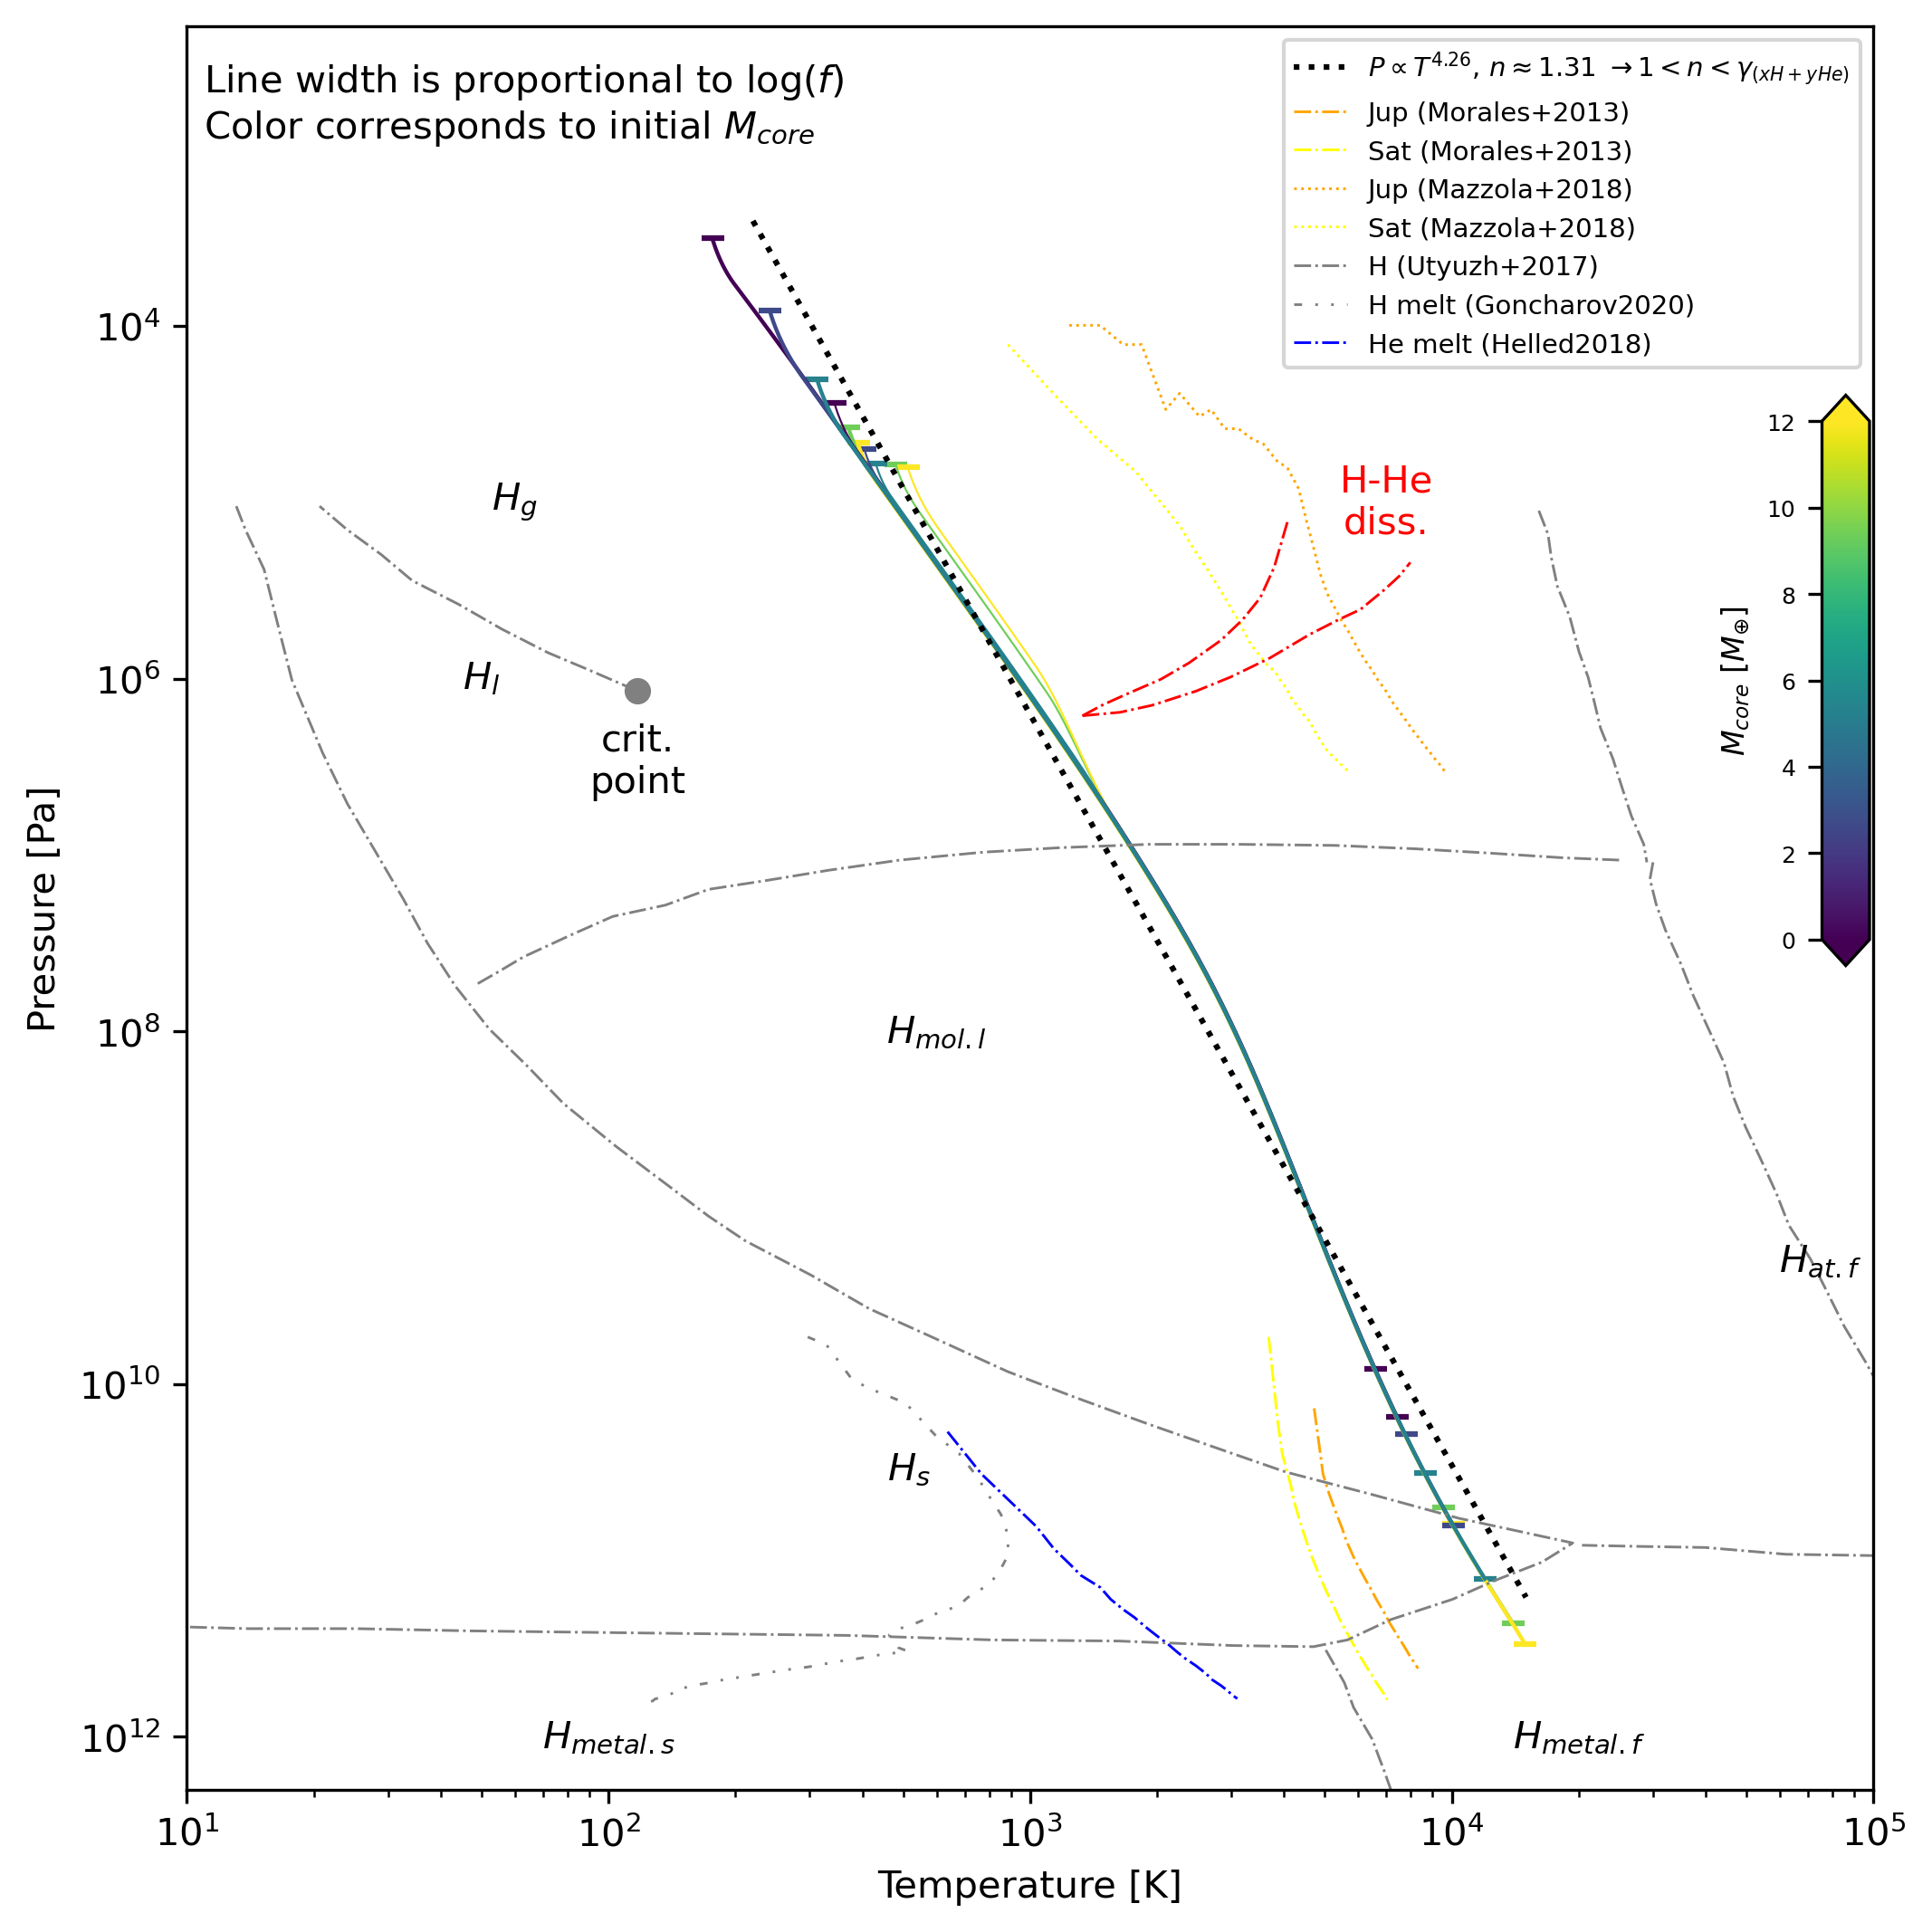

In [71]:
%matplotlib inline
# from zone_properties: 'logT', 'logP'
planets = reduce_to_ass_zone(['logT', 'logP'])
planets = get_final_values_from_zones(planets)

fig, ax0 = plt.subplots(constrained_layout=True, figsize=(7,7))

def generate_temp_pressure_plt_trace(planet):
    m_core = planet[0]
    f = planet[1]
    logT = 10 ** planet[2]["logT"].to_numpy()
    logP = 10 ** planet[2]["logP"].to_numpy()

    ax0.plot(logT, logP, ls="solid", linewidth=lw_f(f, max=0.3), c=color_m_core(m_core, max=12, min=3))
    ax0.scatter(logT[-1], logP[-1], color=color_m_core(m_core, max=12, min=3), marker="_")
    ax0.scatter(logT[0], logP[0], color=color_m_core(m_core, max=12, min=3), marker="_")

    # ax0.scatter(logT, logP, color="black", marker="+", s=6, linewidths=0.3)

    return [logT , logP]

result = np.array([generate_temp_pressure_plt_trace(planet) for planet in planets], dtype=object).T

T = np.concatenate(result[0], axis=-1)
P = np.concatenate(result[1], axis=-1)

# ax0.scatter(T, P, s=8)

def T_P_power_law(T, a, b, offset):
    return b * T ** (a) + offset

def T_P_power_law_alt(T, a, b, c, offset1, offset2):
    return c * b ** (a * T + offset2) + offset1

def T_P_liner_power_law(T, a, offset1):
    return a * T + offset1

def TT_P_power_law(T, a, b, offset):
    return T ** (a + b * T) + offset

T_space = np.logspace(2, 4.5, 200)


T_space = np.linspace(220, 15000, 200)

# para = curve_fit(T_P_power_law, np.log10(T), np.log10(P), ) # p0=[1, 1, -5.0e9])
# para_a, para_b, offset = para[0]
# coef = para[1]
# ax0.plot(10 ** T_space, 10 ** T_P_power_law(T_space, para_a, para_b, offset), color="black", ls="dashed", label="Fit")
#
# para = curve_fit(T_P_power_law_alt, np.log10(T), np.log10(P), ) #p0=[1, 1, -5.0e9])
# para_a, para_b, para_c, offset1, offset2 = para[0]
# coef = para[1]
# ax0.plot(10 ** T_space, 10 ** T_P_power_law_alt(T_space, para_a, para_b, para_c, offset1, offset2), color="black", ls="dotted", label="Fit 2")

para = curve_fit(T_P_liner_power_law, np.log10(T), np.log10(P), ) #p0=[1, 1, -5.0e9])
para_a, offset1 = para[0]
coef = para[1]
ax0.plot(T_space, 10 ** T_P_liner_power_law(np.log10(T_space), para_a, offset1), color="black", ls="dotted", label=f"$P\propto T^{{{para_a:.2f}}}$, $n\\approx 1.31$ $ \\rightarrow 1 < n <\\gamma_{{(x H +y He)}}$")

ax0.set_xlabel("Temperature [K]")
ax0.set_ylabel("Pressure [Pa]")
ax0.invert_yaxis()

ax0.set_xscale("log")
ax0.set_yscale("log")

df = pd.read_csv("h_extreme.csv", header=0, skiprows=1)

hp = df["X"].to_numpy() * 10 ** 9
ht = df["Y"].to_numpy()



start_idx = 6
start_idx_0 = 4
df = pd.read_csv("jup-sat-highP.csv", header=0, skiprows=1)
p = df["X"].to_numpy()[start_idx+7:]
t = df["Y"].to_numpy()[start_idx+7:]
ax0.plot(t, p, color="orange", ls="-.", lw=0.7, label="Jup (Morales+2013)")
p = df["X.1"].to_numpy()[start_idx:]
t = df["Y.1"].to_numpy()[start_idx:]
ax0.plot(t, p, color="yellow", ls="-.", lw=0.7, label="Sat (Morales+2013)")
_p = df["X.2"].to_numpy()[start_idx_0:]
_t = df["Y.2"].to_numpy()[start_idx_0:]

df = pd.read_csv("jup-sat-lowP.csv", header=0, skiprows=1)
p = df["X"].to_numpy()
t = df["Y"].to_numpy()
ax0.plot(t, p, color="orange", ls="dotted", lw=0.7, label="Jup (Mazzola+2018)")
p = df["X.1"].to_numpy()
t = df["Y.1"].to_numpy()
ax0.plot(t, p, color="yellow", ls="dotted", lw=0.7, label="Sat (Mazzola+2018)")

df = pd.read_csv("H-He-mixing.csv", header=0, skiprows=1)
p = df["X"].to_numpy()
t = df["Y"].to_numpy()
ax0.plot(t, p, color="red", ls="-.", lw=0.7, label="")
p = df["X.1"].to_numpy()
t = df["Y.1"].to_numpy()
ax0.plot(t, p, color="red", ls="-.", lw=0.7)

df = pd.read_csv("H_overall.csv", header=0, skiprows=1)
p = df["X"].to_numpy()
t = df["Y"].to_numpy()
ax0.plot(t, p, color="gray", ls="-.", lw=0.7, label="H (Utyuzh+2017)")

ax0.plot(ht, hp, color="gray", ls=(0, (3, 5, 1, 5, 1, 5)), lw=0.7, label="H melt (Goncharov2020)")

ax0.plot(_t, _p, color="blue", ls="-.", lw=0.7, label="He melt (Helled2018)")

for i in range(1, 9):
    p = df[f"X.{i}"].to_numpy()
    t = df[f"Y.{i}"].to_numpy()
    ax0.plot(t, p, color="gray", ls="-.", lw=0.7)

    # ax0.annotate(f"{i}",  xy=(t[0], p[0]),
    #          xycoords='data', ha="center", va="center")

ax0.scatter(df[f"Y.5"].to_numpy()[0], df[f"X.5"].to_numpy()[0], marker="o", color="gray")
ax0.annotate(f"crit.\npoint",  xy=(df[f"Y.5"].to_numpy()[0], df[f"X.5"].to_numpy()[0] * 1.5),
         xycoords='data', ha="center", va="top")

ax0.annotate(r"$H_{s}$",  xy=(580, 24 * 10 ** 9),
             xycoords='data', ha="right", va="top")

ax0.annotate(r"$H_{mol. l}$", xy=(6e2, 1e8),
             xycoords='data', ha="center", va="center")

ax0.annotate(r"$H_{l}$", xy=(5e1, 1e6),
             xycoords='data', ha="center", va="center")

ax0.annotate(r"$H_{g}$", xy=(6e1, 1e5),
             xycoords='data', ha="center", va="center")

ax0.annotate(r"$H_{at. f}$", xy=(7.5e4, 2e9),
             xycoords='data', ha="center", va="center")

ax0.annotate(r"$H_{metal. s}$", xy=(1e2, 1e12),
             xycoords='data', ha="center", va="center")

ax0.annotate(r"$H_{metal. f}$", xy=(2e4, 1e12),
             xycoords='data', ha="center", va="center")

ax0.annotate(r"$H_{plasma}$", xy=(1e6, 1e7),
             xycoords='data', ha="center", va="center")

ax0.annotate("H-He\ndiss.",  xy=(7e3, 1e5),
             xycoords='data', ha="center", va="center", color="red")

ax0.legend(fontsize=7)

t = "Line width is proportional to $\log(f)$\nColor corresponds to initial $M_{core}$"
ax0.annotate(t, xy=(0.01, 0.98), xycoords='axes fraction', ha="left", va="top")

cax = fig.add_axes([0.95, 0.5, 0.025, 0.3])

norm = mpl.colors.Normalize(vmin=0, vmax=12)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=cax, orientation='vertical',
                               # norm=mpl.colors.Normalize(0, 12),  # vmax and vmin
                               extend='both',
                               # label="$M_{core}$ [$M_{\oplus}$]",
                               # ticks=[0, 3, 6, 9],
                  )
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, fontsize=6)
cb.set_label("$M_{core}$ [$M_{\oplus}$]", fontsize=8)


ax0.set_xlim(10, 1e5)
ax0.set_ylim(2e12, 2e2)

plt.savefig("temp_pressure.png", dpi=350)
plt.show()

# Questions
1. Units documentation
2. Star age, mass of star or of planet?
3. Configuration? Star flux, no evaporation etc...?
4. Polytropes
5. Configuration, parameterization (wrt m_core, f), model/theory?

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2